# Suppression of the laser light fluctuations in a wide-field iSCAT measurement 
In this tutorial, we normalize the recorded power in each video frame in order to suppress the temporal instability of the laser light. By doing so we also touch upon the usage of some of the very basic PiSCAT packages such as the  [InputOutput module](https://piscat.readthedocs.io/code_reference.html#piscat-inputoutput) which provides functionalities for loading iSCAT videos and performing some basic checks on the acquisition process through the recorded meta-data. The [Visualization module](https://piscat.readthedocs.io/code_reference.html#piscat-visualization) provides a variety of data visualization tools for inspecting iSCAT videos and presentating the analysis results. The normalization of laser light fluctuations is one of the early-stage analysis tools that are in the [Preprocessing module](https://piscat.readthedocs.io/code_reference.html#piscat-preproccessing). Based on the number of available CPU cores for parallel processing, this tutorial needs 2-3 GB of computer memory (RAM) to run.

## Setting up the PiSCAT modules and downloading a demo iSCAT video

In [1]:
# Only to ignore warnings 
import warnings
warnings.filterwarnings('ignore')

# Setting up the path to the PiSCAT modules
import os
import sys
current_path = os.path.abspath(os.path.join('..'))
dir_path = os.path.dirname(current_path)
module_path = os.path.join(dir_path)
if module_path not in sys.path:
    sys.path.append(module_path)
    
# Downloading a blank video for this tutorial
from piscat.InputOutput import download_tutorial_data
download_tutorial_data('control_video')


Directory  F:\PiSCAT_GitHub_public\PiSCAT\piscat\Tutorials  already exists

The directory with the name  Demo data  already exists in the following path: F:\PiSCAT_GitHub_public\PiSCAT\piscat\Tutorials


Button(description='Download', icon='cloud-download', style=ButtonStyle())

100% [......................................................................] 119767169 / 119767169
Start unzip files --->Done


## The binary iSCAT videos in a path and loading videos 
In this section, we tabulate all the image and video files of a certain data type which are available in a particular path and demonstrate how to read one exemplary video. We mainly use PhotonFocus cameras and store its recordings as binary files. Here we work on the video that was downloaded earlier. 

In [2]:
import numpy as np
from piscat.InputOutput import reading_videos

#Setting up the path to a data set of the type 'raw' in a particular path 'data_path'
data_path = os.path.join(dir_path, 'Tutorials', 'Demo data', 'Control')
df_video = reading_videos.DirectoryType(data_path, type_file='raw').return_df()
paths = df_video['Directory'].tolist()
video_names = df_video['File'].tolist()

#Choosing the first entry in the video list and loading it
demo_video_path = os.path.join(paths[0], video_names[0])
video = reading_videos.video_reader(file_name=demo_video_path, type='binary', img_width=128, img_height=128, 
                                    image_type=np.dtype('<u2'), s_frame=0, e_frame=-1)

help(reading_videos.video_reader)#Calling help on an imported module/class to know more about it.


Help on function video_reader in module piscat.InputOutput.reading_videos:

video_reader(file_name, type='binary', img_width=128, img_height=128, image_type=dtype('float64'), s_frame=0, e_frame=-1)
    This is a wrapper that can be used to call various video/image readers.
    
    Parameters
    ----------
    file_name: str
        Path of video and file name, e.g. test.jpg.
    
    type: str
        Define the video/image format to be loaded.
    
            * 'binary': use this flag to load binary
            * 'tif': use this flag to load tif
            * 'avi': use this flag to load avi
            * 'png': use this flag to load png
            * 'fits': use this flag to load fits
            * 'fli': use this flag to load fli
    
    
    optional_parameters:
        These parameters are used when video 'bin_type' define as binary.
    
        img_width: int
             For binary images, it specifies the image width.
    
        img_height: int
            For binary ima

## Display and inspect a loaded video
As mentioned earlier, the [Visualization module](https://piscat.readthedocs.io/code_reference.html#piscat-visualization) consists of several classes which provide display functionalities. Some of these classes may have the word `jupyter` in their name, for example, `display_jupyter`. The reason behind this is that such a class has functionalities similar to its twin class namely `display`, but adjusted to be used in Jupyter notebooks. The median filter flag passed as an argument to the display classes can be used to achieve a proper visualization of a video albeit having hot or dead pixels. In order to scroll left/right through the video frames, you can use the mouse wheel as well as the keyboard arrows button. The last line in these images is the meta-data of the measurement that the PhotonFocus camera records in each frame as the status-line.

In [3]:
#For Jupyter notebooks only:
%matplotlib inline

from piscat.Visualization import JupyterDisplay_StatusLine
JupyterDisplay_StatusLine(video, median_filter_flag=False, color='gray', imgSizex=5, imgSizey=5, IntSlider_width='500px', 
                          step=1)

---Status line detected in column---


interactive(children=(IntSlider(value=0, continuous_update=False, description='Frame:', layout=Layout(width='5…

## Examining the status line & removing it
The status of the frame-acquisition process is encoded in the status line at the last row of an image. We check out the status line to make sure that all the images are recorded properly in high frame rate measurements. In such measurements, the acquisition buffer can overflow and some frames could be missed in the recording process.

In [4]:
from piscat.InputOutput import read_status_line
from piscat.Visualization import JupyterDisplay
from IPython.display import display

status_ = read_status_line.StatusLine(video)
video_remove_status, status_information  = status_.find_status_line()

JupyterDisplay(video_remove_status, median_filter_flag=False, color='gray', imgSizex=5, imgSizey=5, IntSlider_width='500px', 
               step=10)

---Status line detected in column---


interactive(children=(IntSlider(value=10, continuous_update=False, description='Frame:', layout=Layout(width='…

## Normalization of the power in the frames of a video
The [Preprocessing module](https://piscat.readthedocs.io/code_reference.html#piscat-preproccessing) provides several normalization techniques. In the following step, we correct for the fluctuations in the laser light intensity. The summation of all the pixels in an image is the recorded power $P$ in that frame which is then used to form the average frame power in a video through $\overline{P}$. The corresponding normalization subroutine returns both the power normalized video and the fluctuations in power given by $P/\overline{P} -1$ [[1](http://iopscience.iop.org/article/10.1088/1361-6463/ac2f68)]. The fluctuating trend as demonstrated below is in the order of 1E-3 which is in and above the range of contrasts that we expect from single proteins of mass few tens of kDa.


start power_normalized without parallel loop---> Done


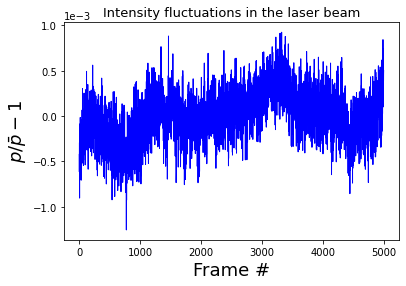

In [5]:
# Normalization of the power in the frames of a video
from piscat.Preproccessing import Normalization
video_pn, power_fluctuation = Normalization(video=video_remove_status).power_normalized()

import matplotlib.pyplot as plt
plt.plot(power_fluctuation, 'b', linewidth=1, markersize=0.5)
plt.xlabel('Frame #', fontsize=18)
plt.ylabel(r"$p / \bar p - 1$", fontsize=18)
plt.title('Intensity fluctuations in the laser beam', fontsize=13)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

## Save a video
Finally, we save an analyzed video again as a binary file in order to demonstrate video writing functionalities of the [InputOutput module](https://piscat.readthedocs.io/code_reference.html#piscat-inputoutput).

In [6]:
from piscat.InputOutput import write_video
write_video.write_binary(dir_path=data_path, file_name='demo_1_output.bin', data=video_remove_status, type='original')

Directory  20221111-164214  Created 


'F:\\PiSCAT_GitHub_public\\PiSCAT\\piscat\\Tutorials\\Demo data\\Control\\20221111-164214'

### Bibliography
1. [Mirzaalian Dastjerdi, Houman, et al. "Optimized analysis for sensitive detection and analysis of single proteins via interferometric scattering microscopy." Journal of Physics D: Applied Physics (2021).](http://iopscience.iop.org/article/10.1088/1361-6463/ac2f68)